In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
table = pd.read_csv('Heston_data_input')
X = table.drop(['C_price','delta'], axis=1)
y = table[['C_price']]
#X = df[['k','T','C_price']]
#y = df[['v0','rho','kappa','theta','sigma']]

In [3]:
table['C_price'].describe()

count    63.000000
mean      0.285844
std       0.134396
min       0.005952
25%       0.251236
50%       0.289855
75%       0.381712
max       0.452502
Name: C_price, dtype: float64

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.2, random_state=42)
input_scaler = preprocessing.MinMaxScaler()
output_scaler = preprocessing.MinMaxScaler()
X_train_scaled = input_scaler.fit_transform(X_train)
#y_train_scaled = output_scaler.fit_transform(y_train)
#y_train_scaled = y_train # no scaling
#X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0],X_train_scaled.shape[1],1) # for lstm
X_test_scaled = input_scaler.transform(X_test)
#y_test_scaled = y_test # no scaling

X_train_scaled = torch.FloatTensor(X_train_scaled)
X_test_scaled = torch.FloatTensor(X_test_scaled)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

In [44]:

num_neurons = 128


class Net(nn.Module):

    def __init__(self,num_input=7):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_input, num_neurons) 
        self.fc2 = nn.Linear(num_neurons, num_neurons)
        self.fc3 = nn.Linear(num_neurons, num_neurons)
#        self.fc4 = nn.Linear(num_neurons, num_neurons)
#        self.fc5 = nn.Linear(num_neurons, num_neurons)
#        self.fc6 = nn.Linear(num_neurons, num_neurons)
        self.fc7 = nn.Linear(num_neurons, 1)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
#        x = F.relu(self.fc4(x))
#        x = F.relu(self.fc5(x))
#        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        return x

def weights_init(m,init_type='normal'):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
#        torch.nn.init.normal_(m.weight)
#        xavier(m.weight.data)
#        xavier(m.bias.data)


In [45]:
model = Net()
model.apply(weights_init)
        
print(model)

Net(
  (fc1): Linear(in_features=7, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc7): Linear(in_features=128, out_features=1, bias=True)
)


# Training

In [46]:
epochs = 30001
loss_arr = []
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-3)
l2_lambda = 1e-5
criterion = nn.MSELoss()


for i in range(epochs):
    y_hat = model.forward(X_train_scaled)
    loss = criterion(y_hat, y_train)
    l2_reg = torch.tensor(0.)
    for param in model.parameters():
        l2_reg += torch.norm(param)
        loss += l2_lambda * l2_reg
    loss_arr.append(loss)
    
 
    if i % 500 == 0:
        print(f'Epoch: {i} Loss: {loss}')
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0 Loss: 0.10582204163074493
Epoch: 500 Loss: 0.10574944317340851
Epoch: 1000 Loss: 0.10567964613437653
Epoch: 1500 Loss: 0.10561220347881317
Epoch: 2000 Loss: 0.10554678738117218
Epoch: 2500 Loss: 0.10548318177461624
Epoch: 3000 Loss: 0.10542119294404984
Epoch: 3500 Loss: 0.10536069422960281
Epoch: 4000 Loss: 0.1053016260266304
Epoch: 4500 Loss: 0.10524392873048782
Epoch: 5000 Loss: 0.1051875576376915
Epoch: 5500 Loss: 0.10513252764940262
Epoch: 6000 Loss: 0.105078786611557
Epoch: 6500 Loss: 0.10502637922763824
Epoch: 7000 Loss: 0.10497531294822693
Epoch: 7500 Loss: 0.10492558777332306
Epoch: 8000 Loss: 0.10487724840641022
Epoch: 8500 Loss: 0.10483035445213318
Epoch: 9000 Loss: 0.10478486865758896
Epoch: 9500 Loss: 0.10474087297916412
Epoch: 10000 Loss: 0.10469843447208405
Epoch: 10500 Loss: 0.1046580821275711
Epoch: 11000 Loss: 0.10461954772472382
Epoch: 11500 Loss: 0.10458248853683472
Epoch: 12000 Loss: 0.10454699397087097
Epoch: 12500 Loss: 0.10451310127973557
Epoch: 13000 Lo

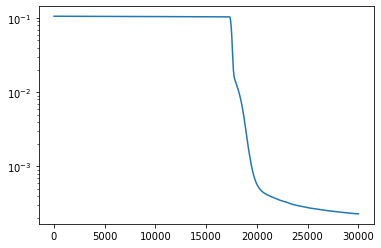

In [47]:
plt.plot(loss_arr)
plt.yscale('log')

In [63]:
inp = copy.deepcopy(X_train_scaled[0])
inp.requires_grad = True

In [66]:
out=model.forward(inp)

In [68]:
out.backward()

In [113]:
inp.grad

tensor([-1.6345e-01,  3.7201e-21,  7.4784e-02, -1.2617e-03, -2.1014e-01,
         9.2801e-04, -2.1151e-01])

In [95]:
inp1 = copy.deepcopy(X_train_scaled[0])
dx = 1e-4
inp1[0] = torch.add(inp1[0],dx)

In [108]:
out1= model.forward(inp1)
dy = out1 - out
print(dy)

tensor([-1.6361e-05], grad_fn=<SubBackward0>)


In [110]:
dydx = dy/dx

In [111]:
dydx

tensor([-0.1636], grad_fn=<DivBackward0>)